In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from sglm.models import sglm_cv
import itertools
import time
import glob
import numpy as np
import pandas as pd
import numpy as np
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import setup_model_fit as smf
from sglm.models import sglm_cv
from sglm import models
from sglm.visualization import visualize
from sglm.models import train_model
from sglm.models import eval
from sglm import features
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
# def dfrel_to_ho_set():
#     return


In [5]:

# from logging.config import _RootLoggerConfiguration

def create_folder_if_not_exists(dr):
    dr = Path(dr)
    constructed_dir = str(Path('/').resolve())
    made = False
    
#     print('constructed_dir', constructed_dir)
    for fold in dr.parts:
        if len(fold) == 0:
            continue
        constructed_dir = str((Path(constructed_dir) / fold).resolve())
#         print('constructed_dir', constructed_dir)
        if os.path.isdir(constructed_dir):
            # print(f'Directory already exists:', constructed_dir)
            pass
        else:
            # print(f'Creating directory:', constructed_dir)
            os.mkdir(constructed_dir)
            made = True
    if made:
        print(f'Created directory:', constructed_dir)
    return

# create_folder_if_not_exists((Path.home() / 'Desktop/nada/folder2').resolve())

In [6]:
def create_all_folders(base_folder, prefix, *args):
    for folder in args:
        create_folder_if_not_exists(str(Path(base_folder/prefix/folder).resolve()))

In [7]:


# From stack overflow
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [8]:
def extract_multifiles(wt_used, signal_files, widest_orders, multifile_fit):
    # needed info
    # Params: wt_used, signal_files, widest_orders, multifile_fit
    # Returns: mouse_names, combo_dfs, combo_fns, X_cols_sftd
    
    if multifile_fit == 'all':
        combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep(signal_files, widest_orders,)
        combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
        mouse_names = combo_fns
    elif multifile_fit == 'by_mouse':
        combo_dfs = []
        X_cols_sftd_lst = []
        combo_fns = []
        mouse_names_2 = []
        for mouse_id in wt_used:
            mouse_id_files = [_ for _ in signal_files if mouse_id in _]
            mouse_names_2 += [mouse_id]
            print('mouse_id', mouse_id)
            combo_dfs_tmp, X_cols_sftd_tmp, _ = smf.multi_file_analysis_prep(mouse_id_files, widest_orders,)
            combo_dfs += combo_dfs_tmp
            X_cols_sftd_lst.append(X_cols_sftd_tmp)
            combo_fns.append(mouse_id)

        for xcsl in X_cols_sftd_lst:
            if xcsl != X_cols_sftd_lst[0]:
                raise ValueError('X_cols_sftd_lst should contain the same elements for every entry')
        mouse_names = mouse_names_2

        X_cols_sftd = X_cols_sftd_lst[0]

    elif multifile_fit == 'single':
        combo_dfs, X_cols_sftd, combo_fns = smf.single_file_analysis_prep(signal_files, widest_orders,)
        mouse_names = mouse_names
    else:
        raise ValueError('multifile_fit must be "all", "single", or "by_mouse"')

    return mouse_names, combo_dfs, combo_fns, X_cols_sftd

In [9]:
def id_rows_with_all_cols(dfrel_basis,
                          X_y_pairings,
                          X_cols_sftd, 
                          drop_cols_basis = ['nTrial', 'nTrial_filenum', 'cpn', 'cpx', 'spnnr', 'spxnr', 'spnr', 'spxr',
                                             
                                             'photometryCenterInIndex', 'photometryCenterOutIndex',
                                             'photometrySideInIndexr', 'photometrySideInIndexnr',
                                             'photometrySideOutIndex', 'spnnrOff',
                                             
                                             'photometrySideInIndexAA', 'photometrySideInIndexAa',
                                             'photometrySideInIndexaA', 'photometrySideInIndexaa',
                                             'photometrySideInIndexAB', 'photometrySideInIndexAb',
                                             'photometrySideInIndexaB', 'photometrySideInIndexab',
                                             'sl', 'slOff'
                                            ]):
    full_drop_basis = []
    y_col_lst = []
    for X_y_dct in X_y_pairings:
        full_drop_basis += bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
        y_col_lst += [X_y_dct['y_col']]
    y_col_drop_basis = sorted(list(set(y_col_lst)))
    full_drop_basis = sorted(list(set(drop_cols_basis + full_drop_basis + y_col_drop_basis)))

    num_cols_na = (dfrel_basis[full_drop_basis].isna().sum(axis=1))
    num_y_0 = (dfrel_basis[y_col_drop_basis] == 0).sum(axis=1)
    has_all_cols = (num_cols_na == 0)&(num_y_0 == 0)

    return has_all_cols

In [10]:
def get_perc_words(signal_df, betas_df, total_col='photometrySideInIndex', words_prefix='photometrySideInIndex', words=['AA', 'Aa', 'aA', 'aa', 'AB', 'Ab', 'aB', 'ab'], perc_suffix='_cnt_tr'):
    
    tot_trials = signal_df[total_col].sum()
    
    betas_df[perc_suffix] = tot_trials
    betas_df[f'AA{perc_suffix}'] = signal_df[f'{words_prefix}AA'].sum()/tot_trials
    betas_df[f'Aa{perc_suffix}'] = signal_df[f'{words_prefix}Aa'].sum()/tot_trials
    betas_df[f'aA{perc_suffix}'] = signal_df[f'{words_prefix}aA'].sum()/tot_trials
    betas_df[f'aa{perc_suffix}'] = signal_df[f'{words_prefix}aa'].sum()/tot_trials
    betas_df[f'AB{perc_suffix}'] = signal_df[f'{words_prefix}AB'].sum()/tot_trials
    betas_df[f'Ab{perc_suffix}'] = signal_df[f'{words_prefix}Ab'].sum()/tot_trials
    betas_df[f'aB{perc_suffix}'] = signal_df[f'{words_prefix}aB'].sum()/tot_trials
    betas_df[f'ab{perc_suffix}'] = signal_df[f'{words_prefix}ab'].sum()/tot_trials
    
    return betas_df

In [11]:
pr = lambda x: str(Path(x).resolve())
ps = lambda x: str(Path(x))

# base_folder = '/home/josh/github-repos/sabatinilab-glm/sglm/outputs'
base_folder = (Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs').resolve())
# base_folder = '/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs'
base_folder = (Path(base_folder).resolve())

all_reconstruct_folder = ps('reconstructs/all')
best_reconstruct_folder = ps('reconstructs/best')
all_coefs_folder = ps('coefs/all')
best_coefs_folder = ps('coefs/best')
mses_folder = ps('mses')

neg_order = -20
pos_order = 20

# data_folder = 'test'
data_folder = 'fig1'
# data_folder = 'fig3'
# data_folder = 'fig3-dualhem'
# data_folder = 'fig5/g1'
# data_folder = 'fig5/g2'
# data_folder = 'fig5/g3'
# data_folder = 'fig5/g4'
# data_folder = 'fig5/g5'

fix_training = True #False

multifile_fit_list = ['all']
# multifile_fit_list = ['by_mouse', 'all']

# base_prefix = f'oall-testhdf-4'
base_prefix = f'oall-testhdf-5-shortkern'

In [12]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [13]:
# def func_for_cprofile():
ft_str = '-ft' if fix_training else ''

if data_folder == 'test':
    wt_used = [
        'WT63', 'WT64', 'WT53', 'WT69'
    ]

elif data_folder == 'fig1':

    wt_used = [
               'WT63', 'WT64', 'WT65', 'WT66', 'WT67', 'WT68', 'WT69', # DA
               'WT57', 'WT58', 'WT59', 'WT60', 'WT61', 'WT53', 'WT55', 'WT56' # ACH
               ]

elif data_folder == 'fig3':
    wt_used = ['WT61', 'WT63', 'WT64', 'WT44', 'WT51']
elif data_folder == 'fig3-dualhem':
    wt_used = ['WT63', 'WT64', 'WT65']

elif data_folder == 'fig4/g1':
    wt_used = ['S1233', 'S1234', 'S1260', 'S1246', 'S1248']
elif data_folder == 'fig4/g2':
    wt_used = ['S1194', 'S1195', 'S1214', 'S1258', 'S1259']

elif data_folder == 'fig5/g1': # Drd2f/f control: S1417, 1419, 1421
    # wt_used = ['S1417', 'S1419', 'S1421']
    wt_used = ['S1417', 'S1419', 'S1421', 'S1460', 'S1462', 'S1473', 'S1474']
elif data_folder == 'fig5/g2': # Chat Cre X Drd2f/f : S1416, 1418, 1420, 1422
    # wt_used = ['S1416', 'S1418', 'S1420', 'S1422']
    wt_used = ['S1416', 'S1418', 'S1420', 'S1459', 'S1461', 'S1470', 'S1471', 'S1472']
elif data_folder == 'fig5/g3': # Chat Cre control: S1355-1358, S1374, S1376
    # wt_used = ['S1355', 'S1356', 'S1357', 'S1358', 'S1374', 'S1376']
    wt_used = ['S1355', 'S1356', 'S1357', 'S1358', 'S1374', 'S1376',
               'S1448', 'S1449', 'S1450', 'S1451']
elif data_folder == 'fig5/g4': # Chat Cre control: S1399-1401
    # wt_used = ['S1399', 'S1400', 'S1401']
    wt_used = ['S1399', 'S1400', 'S1401']
elif data_folder == 'fig5/g5':
    # wt_used = ['S1355', 'S1356', 'S1357', 'S1358', 'S1374', 'S1376', 'S1399', 'S1400', 'S1401']
    wt_used = ['S1355', 'S1356', 'S1357', 'S1358', 'S1374', 'S1376',
               'S1448', 'S1449', 'S1450', 'S1451'
               'S1399', 'S1400', 'S1401']
elif data_folder == 'fig5/g6':
    wt_used = []
else:
    raise ValueError('Unimplemented figure values.')

data_folder_src = data_folder if data_folder != 'test' else 'fig1'
data_folder_join = '_'.join(Path(data_folder).parts)

num_runs = 10

### Backwards Selection
X_y_pairings_lst = []

X_y_pairings_lst += [[
    {'X_cols': {
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),                
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
               },
     'y_col': 'gACH',
     'name': 'base_simple'
     },
#     {'X_cols': {
#                 # 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_CI'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 # 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_CO'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 # 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_SI'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 # 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_SIr'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 # 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_SO'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 # 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_sl'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 # 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'no_spnnrOff'},
#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndexAA':(0,0),
#                 'photometrySideInIndexAa':(0,0),
#                 'photometrySideInIndexaA':(0,0),
#                 'photometrySideInIndexaa':(0,0),
#                 'photometrySideInIndexAB':(0,0),
#                 'photometrySideInIndexAb':(0,0),
#                 'photometrySideInIndexaB':(0,0),
#                 'photometrySideInIndexab':(0,0),
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gACH',
#      'name': 'base_words'},

]]

# X_y_pairings_lst += [[

#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),                
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'rDA',
#      'name': 'base_simple'
#      },
# #     {'X_cols': {
# #                 # 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_CI'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 # 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_CO'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 # 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_SI'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 # 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_SIr'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 # 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_SO'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 # 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_sl'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 # 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'no_spnnrOff'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndexAA':(0,0),
# #                 'photometrySideInIndexAa':(0,0),
# #                 'photometrySideInIndexaA':(0,0),
# #                 'photometrySideInIndexaa':(0,0),
# #                 'photometrySideInIndexAB':(0,0),
# #                 'photometrySideInIndexAb':(0,0),
# #                 'photometrySideInIndexaB':(0,0),
# #                 'photometrySideInIndexab':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'rDA',
# #      'name': 'base_words'},

# ]]

# X_y_pairings_lst += [[

#     {'X_cols': {
#                 'photometryCenterInIndex':(0,0),
#                 'photometryCenterOutIndex':(0,0),
#                 'photometrySideInIndex':(0,0),
#                 'photometrySideInIndexr':(0,0),                
#                 'photometrySideOutIndex':(0,0),
#                 'sl': (0,0),
#                 'spnnrOff': (0,0),
#                },
#      'y_col': 'gDA',
#      'name': 'base_simple'
#      },
# #     {'X_cols': {
# #                 # 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_CI'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 # 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_CO'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 # 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_SI'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 # 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_SIr'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 # 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_SO'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 # 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_sl'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndex':(0,0),
# #                 'photometrySideInIndexr':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 # 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'no_spnnrOff'},
# #     {'X_cols': {
# #                 'photometryCenterInIndex':(0,0),
# #                 'photometryCenterOutIndex':(0,0),
# #                 'photometrySideInIndexAA':(0,0),
# #                 'photometrySideInIndexAa':(0,0),
# #                 'photometrySideInIndexaA':(0,0),
# #                 'photometrySideInIndexaa':(0,0),
# #                 'photometrySideInIndexAB':(0,0),
# #                 'photometrySideInIndexAb':(0,0),
# #                 'photometrySideInIndexaB':(0,0),
# #                 'photometrySideInIndexab':(0,0),
# #                 'photometrySideOutIndex':(0,0),
# #                 'sl': (0,0),
# #                 'spnnrOff': (0,0),
# #                },
# #      'y_col': 'gDA',
# #      'name': 'base_words'},

# ]]


plot_width = 2
max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
plot_rows_lst = [_//plot_width + (_%plot_width > 0)*1 for _ in max_cols_len_lst]


dfrr_cols = ['file_num', 'nTrial', 'nTrial_filenum', 'nEndTrial', 'wi_trial_keep',
             'nTrial_hard', 'nEndTrial_hard', 'diffTrialNums_hard', 'wi_trial_keep_hard',
             'has_all_cols', 'gDA', 'gACH', 'rDA',
             'diffTrialNums', 'dupe',
             'photometryCenterInIndex', 'photometryCenterOutIndex',
             'photometrySideInIndexr', 'photometrySideInIndexnr',
             'photometrySideOutIndex', 'spnnrOff', 'sl',

             'photometrySideInIndexAA', 'photometrySideInIndexAa',
             'photometrySideInIndexaA','photometrySideInIndexaa',
             'photometrySideInIndexAB', 'photometrySideInIndexAb',
             'photometrySideInIndexaB','photometrySideInIndexab',
]

score_method = 'r2'

# Select hyper parameters for GLM to use for model selection
# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    'alpha': [0],
    'l1_ratio': [0],

    # 'alpha': [0.0, 0.001, 0.01, 0.1, 1.0],
    # 'l1_ratio': [0.0, 0.0001, 0.001, 0.01],
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'max_iter': 10000,
    'fit_intercept': False
}

folds = 10
pholdout = 0.2
pgss = 0.2

# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)


multi_start = time.time()

for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):

    widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
                                                    'y_col': _['y_col']} for _ in X_y_pairings])
    max_cols_len = max_cols_len_lst[iXyp]
    plot_rows = plot_rows_lst[iXyp]

    for multifile_fit in multifile_fit_list:
        prefix = f'{data_folder_join}/{multifile_fit}/{base_prefix}_{iXyp}{ft_str}'
        create_all_folders(base_folder, prefix,
                           all_reconstruct_folder,
                           best_reconstruct_folder,
                           all_coefs_folder,
                           best_coefs_folder,
                           mses_folder)

        # Load Signal Data
        signal_files = []
        mouse_names = []
        for wt in wt_used:
            addl_sig_files = glob.glob(pr(f'../../data/interim/{data_folder_src}/GLM_SIGNALS_INTERIM_{wt}_*'))
            signal_files += addl_sig_files
            mouse_names += [wt] * len(addl_sig_files)

        mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders, multifile_fit)

        start = time.time()
        results_dict = {}

        for file_num in range(len(combo_fns)):
            # Load Table Data
            dfrel_basis = combo_dfs[file_num].reset_index(drop=False).copy()
            
            dfrel_basis['nTrial_hard'] = dfrel_basis.groupby('file_num')['nTrial'].shift(20)
            dfrel_basis['nEndTrial_hard'] = dfrel_basis.groupby('file_num')['nEndTrial'].shift(-20)
            dfrel_basis['diffTrialNums_hard'] = dfrel_basis['nTrial_hard'] - dfrel_basis['nEndTrial_hard']
            dfrel_basis['wi_trial_keep_hard'] = (dfrel_basis['diffTrialNums_hard'] == 1)
            
            
            
            fn = Path(combo_fns[file_num].split('.')[0]).parts[-1]
            mouse_id = mouse_names[file_num]
            dfresids_cols = np.copy(dfrr_cols).tolist()
            run_id = f'{fn}_{iXyp}'            

            has_all_cols = id_rows_with_all_cols(dfrel_basis, X_y_pairings, X_cols_sftd)
            if has_all_cols.sum() == 0:
                print(f'No datapoints found for non-NaN dropcols & non-zero ycols for fixed_training: {prefix}_{fn}')
                continue
            
            dfrel_basis['has_all_cols'] = has_all_cols
            dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(pr(f'{base_folder}/{prefix}/{best_reconstruct_folder}/best_resids_{run_id}.h5'), key='dfrel_basis', index=True,)
            
            dfrel_basis_has_all_cols = dfrel_basis[has_all_cols]

            for irun in range(num_runs):
                holdout = models.split_data.holdout_split_by_trial_id(dfrel_basis_has_all_cols,
                                                                      id_cols=['nTrial_filenum'],
                                                                      perc_holdout=pholdout)
                dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}'] = holdout
                dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}'] = dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}'].astype(float)

                for iXyd, X_y_dct in enumerate(X_y_pairings):

                    X_cols = bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
                    y_col = X_y_dct['y_col']
                    name = X_y_dct['name']
                    
                    subrun_id = f'{y_col}_{iXyp}_{iXyd}_{name}_run_num__{irun}'
#                     pred_col_name = f'y={y_col}_irun={irun}_iXyd={iXyd}_name={name}'
                    pred_col_name = subrun_id


                    if not fix_training:
                        holdout = models.split_data.holdout_split_by_trial_id(dfrel_basis_has_all_cols, id_cols=['nTrial_filenum'], perc_holdout=pholdout)
#                         dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}_iXyd={iXyd}'] = holdout
                        dfrel_basis[f'holdout_{pred_col_name}'] = holdout
                        dfrel_basis[f'holdout_{pred_col_name}'] = dfrel_basis[f'holdout_{pred_col_name}'].astype(float)
                    else:
#                         dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}_iXyd={iXyd}'] = dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}']
                        dfrel_basis[f'holdout_{pred_col_name}'] = dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}'].astype(float)
                        
                    if (~dfrel_basis[f'holdout_{pred_col_name}'].isna()).sum() == 0:
                        print(f'No datapoints found for non-NaN dropcols & non-zero ycols for run id: {run_id}, {subrun_id}.')
                        continue

#                     df_train = dfrel_basis_has_all_cols[(~holdout)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
#                     df_holdout = dfrel_basis_has_all_cols[(holdout)&(dfrel_basis_has_all_cols['wi_trial_keep'])]

                    #TODO: JZ - CHANGE BACK TO WI_TRIAL_KEEP    
                    df_train = dfrel_basis_has_all_cols[(~holdout)&(dfrel_basis_has_all_cols['wi_trial_keep_hard'])]
                    df_holdout = dfrel_basis_has_all_cols[(holdout)&(dfrel_basis_has_all_cols['wi_trial_keep_hard'])]
                    
                    X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]

                    kfold_cv_idx = models.split_data.cv_idx_by_trial_id(df_train, trial_id_columns=['nTrial_filenum'], num_folds=folds, test_size=pgss)
                    best_score, best_score_std, best_params, best_model, cv_results = models.sglm_cv.simple_cv_fit(X_train, y_train, kfold_cv_idx, glm_kwarg_lst, model_type='Normal',
                                                                                                                verbose=0, score_method=score_method)

                    print('Variable Sizes:')
                    for vname, size in sorted(((vname, sys.getsizeof(value)) for vname, value in locals().items()),
                                             key= lambda x: -x[1])[:30]:
                        print("{:>30}: {:>8}".format(vname, sizeof_fmt(size)))

                    glm, holdout_score, holdout_neg_mse_score = eval.training_fit_holdout_score(X_train, y_train, X_holdout, y_holdout, best_params)

                    betas_df = pd.DataFrame(np.concatenate([np.array([glm.intercept_]), glm.coef_], axis=0).reshape(1,-1),
                                index=[run_id], columns=['int']+X_cols)
                    betas_df['mouse_id'] = mouse_id
                    betas_df['channel_name'] = f'{y_col}_{iXyd}_run_num={irun}'
                    betas_df['name'] = name

                    # Only get R^2 values if only a single model fit
                    assert len(cv_results['full_cv_results']) == 1
                    # TODO: JZ -- IMPLEMENT VERSION FOR MULTIPLE HYPERPARAMETER SWEEPS
                    assert holdout_neg_mse_score == glm.neg_mse_score(X_holdout, y_holdout)

                    betas_df[['mse_tr', 'mse_cv', 'mse_te']] = [[-glm.neg_mse_score(X_train, y_train), cv_results['full_cv_results'][0]['cv_mse_score'], -glm.neg_mse_score(X_holdout, y_holdout)]]
                    betas_df[['r2_tr', 'r2_cv', 'r2_te']] = [[glm.r2_score(X_train, y_train), cv_results['full_cv_results'][0]['cv_R2_score'], glm.r2_score(X_holdout, y_holdout)]]

                    multi_end = time.time()
                    betas_df['timestamp'] = str(multi_end - multi_start) + ' s'

                    betas_df = betas_df.set_index(['mouse_id', 'channel_name', 'name', 'timestamp', 'mse_tr', 'mse_cv', 'mse_te', 'r2_tr', 'r2_cv', 'r2_te'], append=True)

                    word_perc_kwargs = dict(total_col='photometrySideInIndex', words_prefix='photometrySideInIndex', words=['AA', 'Aa', 'aA', 'aa', 'AB', 'Ab', 'aB', 'ab'])
                    betas_df = get_perc_words(df_train, betas_df, perc_suffix='_cnt_tr',  **word_perc_kwargs)
                    betas_df = get_perc_words(df_holdout, betas_df, perc_suffix='_cnt_ho', **word_perc_kwargs)

                    betas_df.to_hdf(pr(f'{base_folder}/{prefix}/{best_coefs_folder}/{run_id}_best_coeffs.h5'), key=subrun_id, index=True)

                    dfrel_basis['pred_'+pred_col_name] = pd.Series(glm.predict(dfrel_basis_has_all_cols[X_cols]),
                                                                                 index=dfrel_basis_has_all_cols.index)
                    dfrel_basis['predALL_'+pred_col_name] = glm.predict(dfrel_basis[X_cols])

                    subset_dfresids_cols = [f'holdout_{pred_col_name}', 'pred_'+pred_col_name, 'predALL_'+pred_col_name]
                    dfresids_cols += subset_dfresids_cols
#                     dfresids_cols += [f'holdout_iXyp={iXyp}_irun={irun}_iXyd={iXyd}', 'pred_'+pred_col_name, 'predALL_'+pred_col_name]
                    
#                     display(dfrel_basis)
                    dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(pr(f'{base_folder}/{prefix}/{best_reconstruct_folder}/best_resids_{run_id}.h5'), key=subrun_id, index=True,)
#                     break
#             dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(pr(f'{base_folder}/{prefix}/{best_reconstruct_folder}/best_resids_fn={fn}_iXyp={iXyp}_all.h5'), key='df', index=True,)
#                 break
#             break
#         break
#     break
# return

# import cProfile
# cprof = cProfile.run('func_for_cprofile()', sort='tottime')

{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0, 'l1_ratio': 0}
Running multi
Running multiRunning multi

Running multi
Multirun queue completedMultirun queue completedMultirun queue completed


{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0, 'l1_ratio': 0}
> cv_mean_score_train: 0.23894360264895215
> cv_R2_score: 0.2365398037831412
> cv_mean_score: 0.2365472057064582
Running multi
Multirun queue completed
Variable Sizes:
                   dfrel_basis:  6.5 GiB
      dfrel_basis_has_all_cols:  4.6 GiB
                      df_train:  1.9 GiB
                       X_train:  1.4 GiB
                    df_holdout: 437.1 MiB
                     X_holdout: 322.4 MiB
                       holdout: 45.8 MiB
                       y_train: 10.2 MiB
                     y_holdout:  2.2 MiB
                  has_all_cols:  2.1 MiB
                          _i13: 25.3 KiB
                        X_cols:  2.6 KiB
                   X_cols_sftd:  2.3 KiB
                        

{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0, 'l1_ratio': 0}
Running multi
Running multi
Running multi
Running multi
Multirun queue completedMultirun queue completedMultirun queue completed


{'max_iter': 10000, 'fit_intercept': False, 'alpha': 0, 'l1_ratio': 0}
> cv_mean_score_train: 0.23848690042492215
> cv_R2_score: 0.23726545036349522
> cv_mean_score: 0.2372559488388981
Running multi
Multirun queue completed
Variable Sizes:
                   dfrel_basis:  6.8 GiB
      dfrel_basis_has_all_cols:  4.6 GiB
                      df_train:  1.9 GiB
                       X_train:  1.4 GiB
                    df_holdout: 446.2 MiB
                     X_holdout: 329.1 MiB
                       holdout: 45.8 MiB
                       y_train: 10.2 MiB
                     y_holdout:  2.3 MiB
                  has_all_cols:  2.1 MiB
                          _i13: 25.3 KiB
                      betas_df:  4.6 KiB
                        X_cols:  2.6 KiB
                   X_co

In [14]:
print('hi')

hi


In [15]:
betas_df

,,,,,,,,,,,int,photometryCenterInIndex_-20,photometryCenterInIndex_-19,photometryCenterInIndex_-18,photometryCenterInIndex_-17,photometryCenterInIndex_-16,photometryCenterInIndex_-15,photometryCenterInIndex_-14,photometryCenterInIndex_-13,photometryCenterInIndex_-12,...,ab_cnt_tr,_cnt_ho,AA_cnt_ho,Aa_cnt_ho,aA_cnt_ho,aa_cnt_ho,AB_cnt_ho,Ab_cnt_ho,aB_cnt_ho,ab_cnt_ho
,mouse_id,channel_name,name,timestamp,mse_tr,mse_cv,mse_te,r2_tr,r2_cv,r2_te,,,,,,,,,,,,,,,,,,,,,
63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0,63_64_65_66_67_68_69_57_58_59_60_61_53_55_56,gACH_0_run_num=9,base_simple,776.4132330417633 s,0.751295,0.751276,0.750468,0.238514,0.240029,0.237731,0.0,0.073647,-0.011459,-0.024694,0.012796,0.048402,0.009707,-0.047209,-0.079482,-0.079335,...,0.035938,2464.0,0.550325,0.112419,0.061282,0.101461,0.008929,0.049919,0.078734,0.036932


In [16]:
dfrel_basis.columns[-12:]

Index(['holdout_iXyp=0_irun=7', 'holdout_gACH_0_0_base_simple_run_num__7',
       'pred_gACH_0_0_base_simple_run_num__7',
       'predALL_gACH_0_0_base_simple_run_num__7', 'holdout_iXyp=0_irun=8',
       'holdout_gACH_0_0_base_simple_run_num__8',
       'pred_gACH_0_0_base_simple_run_num__8',
       'predALL_gACH_0_0_base_simple_run_num__8', 'holdout_iXyp=0_irun=9',
       'holdout_gACH_0_0_base_simple_run_num__9',
       'pred_gACH_0_0_base_simple_run_num__9',
       'predALL_gACH_0_0_base_simple_run_num__9'],
      dtype='object')

In [17]:
dfrel_basis_backup_og = dfrel_basis.copy()

In [18]:
def show_if_has_val(check_srs, x_srs, y_srs, label='label', ax=None):
    if check_srs.abs().sum() > 0:
        ax.plot(x_srs, y_srs, label=label)

def view_trial(df, nTrial, y_col='gACH', pred_col='pred', holdout_col='holdout', dupe_col='dupe', wi_trial_keep_col='wi_trial_keep'):
    if nTrial:
        df = df[df['nTrial_filenum'] == nTrial]
    
    fig,axes = plt.subplots(4,1,figsize=(30,10))
    fig.set_facecolor('w')
    
#     fig.suptitle(f'MSE -- Total: {}')
    
    tax = axes[0]
    tax.grid(True)
    bax = axes[1]
    bax.grid(True)
    bbax = axes[2]
    bbax.grid(True)
    bbbax = axes[3]
    bbbax.grid(True)
    
    show_if_has_val(df['photometryCenterInIndex'], df.index, df['photometryCenterInIndex']+2, label='CI', ax=tax)
    show_if_has_val(df['photometryCenterOutIndex'], df.index, df['photometryCenterOutIndex']+2, label='CO', ax=tax)
    show_if_has_val(df['photometrySideInIndex'], df.index, df['photometrySideInIndex']+2, label='SI', ax=tax)
    show_if_has_val(df['photometrySideOutIndex'], df.index, df['photometrySideOutIndex']+2, label='SO', ax=tax)
    tax.plot(df.index, df[holdout_col]*1, label='isHoldout')
    
    show_if_has_val(df['photometrySideInIndexr'], df.index, df['photometrySideInIndexr']*1+4, label='SIr', ax=tax)
    show_if_has_val(df['photometrySideInIndexnr'], df.index, df['photometrySideInIndexnr']*1+4, label='SInr', ax=tax)
    show_if_has_val(df['spnnrOff'], df.index, df['spnnrOff']*1+4, label='spnnrOff', ax=tax)
    show_if_has_val(df['sl'], df.index, df['sl']*1+4, label='SL', ax=tax)
    
    show_if_has_val(df['photometrySideInIndexAA'], df.index, df['photometrySideInIndexAA']*1+6, label='AA', ax=tax)
    show_if_has_val(df['photometrySideInIndexAa'], df.index, df['photometrySideInIndexAa']*1+6, label='Aa', ax=tax)
    show_if_has_val(df['photometrySideInIndexaA'], df.index, df['photometrySideInIndexaA']*1+6, label='aA', ax=tax)
    show_if_has_val(df['photometrySideInIndexaa'], df.index, df['photometrySideInIndexaa']*1+6, label='aa', ax=tax)
    
    show_if_has_val(df['photometrySideInIndexAB'], df.index, df['photometrySideInIndexAB']*1+6, label='AB', ax=tax)
    show_if_has_val(df['photometrySideInIndexAb'], df.index, df['photometrySideInIndexAb']*1+6, label='Ab', ax=tax)
    show_if_has_val(df['photometrySideInIndexaB'], df.index, df['photometrySideInIndexaB']*1+6, label='aB', ax=tax)
    show_if_has_val(df['photometrySideInIndexab'], df.index, df['photometrySideInIndexab']*1+6, label='ab', ax=tax)
    
    show_if_has_val(df[dupe_col], df.index, df[dupe_col]*1+8, label='isDupe', ax=tax)
    show_if_has_val(df[wi_trial_keep_col], df.index, df[wi_trial_keep_col]*1+8, label='isInTrial', ax=tax)
    
    tax.legend()
    
    bax.plot(df.index, df[y_col], label=f'True - {y_col}')
    bax.plot(df.index, df[pred_col], label=f'Pred - {y_col}')
    
    bax.legend()
    
    bbax.plot(df.index, (df[y_col] - df[pred_col])**2, label='Resid^2')
    bbax.legend()
    
    bbbax.plot(df.index, ((df[y_col] - df[pred_col])**2).cumsum(), label='Cumulative Resid^2')
    bbbax.plot(df.index, ((df[y_col] - df[pred_col])**2 * df['wi_trial_keep']).cumsum(), label='Cumulative Resid^2 -- Within Trial')
    bbbax.legend()


In [19]:
df_lst = []
with pd.HDFStore(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\fig1\all\oall-testhdf-4_0-ft\reconstructs\best\best_resids_63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_0.h5') as hdf:
    print(hdf.keys())
    for key in hdf.keys():
        df_lst.append(pd.read_hdf(hdf, key=key))
#     df_reader = hdf.select('my_table_id', chunksize=10000)

['/dfrel_basis', '/gACH_0_0_base_simple_run_num__0', '/gACH_0_0_base_simple_run_num__1', '/gACH_0_0_base_simple_run_num__2', '/gACH_0_1_no_CI_run_num__0']


In [20]:
# dfrel_basis = df_lst[-2]
dfrel_basis = dfrel_basis_backup_og.copy()

In [32]:
# dfrel_basis = dfrel_basis_backup.copy()
y_col = 'gACH'
Xyd, Xyp = 0, 0
run_num = 8

# for run_num in range(10):
dfrel_basis['resid2'] = (dfrel_basis[y_col] - dfrel_basis[f'pred_{y_col}_{Xyd}_{Xyp}_base_simple_run_num__{run_num}'])**2
dfrel_basis['resid2_wi_trial'] = dfrel_basis['resid2']*(dfrel_basis['wi_trial_keep'].replace(False, np.nan))


dfrel_basis['resid2_wi_trial_hard'] = dfrel_basis['resid2']*(dfrel_basis['wi_trial_keep_hard'].replace(False, np.nan))

# dfrel_basis['resid2_wi_trial_short'] = ((((dfrel_basis['photometryCenterInIndex'].cumsum() - dfrel_basis['photometrySideOutIndex'].cumsum())==1).replace(False, np.nan))*dfrel_basis['resid2'])

df_inspect = dfrel_basis
# df_inspect = dfrel_basis[~dfrel_basis['file_num'].isin([16, 10, 17, 15, 3, 13, 12, 7])]
# df_inspect = hdf[hdf['diffTrialNums'] == 1]
# df_inspect = dfrel_basis[dfrel_basis['wi_trial_keep']]

training_df = df_inspect.query(f'holdout_{y_col}_{Xyd}_{Xyp}_base_simple_run_num__{run_num} == False')
holdout_df = df_inspect.query(f'holdout_{y_col}_{Xyd}_{Xyp}_base_simple_run_num__{run_num} == True')

# print('Num Total', df_inspect.shape[0])
# print('Num Holdout', df_inspect['holdout_gACH_0_0_base_simple_run_num__0'].sum())
# print('Num Nan', df_inspect['holdout_gACH_0_0_base_simple_run_num__0'].isna().sum())

training_mean_resids = (training_df[['resid2', 'resid2_wi_trial', 'resid2_wi_trial_hard']]).mean()
holdout_mean_resids = (holdout_df[['resid2', 'resid2_wi_trial', 'resid2_wi_trial_hard']]).mean()
mean_resids = pd.DataFrame([training_mean_resids.values, holdout_mean_resids.values, (training_mean_resids.values<holdout_mean_resids.values)*1],
                           index=['training', 'holdout', 'correct'],
                           columns=['resid2', 'resid2_wi_trial', 'resid2_wi_trial_hard'])
display(mean_resids)
# display('Training', training_df.shape)
# display('Holdout', holdout_df.shape)

at = training_df.groupby(['file_num', 'nTrial_filenum'])['resid2'].mean().sort_values(ascending=False).head().reset_index()
at = at.rename({_:_+'_all_tr' for _ in at.columns}, axis=1)
ah = holdout_df.groupby(['file_num', 'nTrial_filenum'])['resid2'].mean().sort_values(ascending=False).head().reset_index()
ah = ah.rename({_:_+'_all_ho' for _ in ah.columns}, axis=1)

wit = training_df.groupby(['file_num', 'nTrial_filenum'])['resid2_wi_trial'].mean().sort_values(ascending=False).head().reset_index()
wit = wit.rename({_:_+'_wi_tr' for _ in wit.columns}, axis=1)
wih = holdout_df.groupby(['file_num'])['resid2_wi_trial'].mean().sort_values(ascending=False).head().reset_index()
wih = wih.rename({_:_+'_wi_ho' for _ in wih.columns}, axis=1)

wits = training_df.groupby(['file_num', 'nTrial_filenum'])['resid2_wi_trial_hard'].mean().sort_values(ascending=False).head().reset_index()
wits = wits.rename({_:_+'_wi_tr_hrd' for _ in wits.columns}, axis=1)
wihs = holdout_df.groupby(['file_num', 'nTrial_filenum'])['resid2_wi_trial_hard'].mean().sort_values(ascending=False).head().reset_index()
wihs = wihs.rename({_:_+'_wi_ho_hrd' for _ in wihs.columns}, axis=1)


with pd.option_context('display.max_columns', 1000):
    display(pd.concat([at, ah, wit, wih, wits, wihs], axis=1))

,resid2,resid2_wi_trial,resid2_wi_trial_hard
training,0.846003,0.793506,0.752491
holdout,0.845268,0.787449,0.745093
correct,0.000000,0.000000,0.000000


,file_num_all_tr,nTrial_filenum_all_tr,resid2_all_tr,file_num_all_ho,nTrial_filenum_all_ho,resid2_all_ho,file_num_wi_tr,nTrial_filenum_wi_tr,resid2_wi_trial_wi_tr,file_num_wi_ho,resid2_wi_trial_wi_ho,file_num_wi_tr_hrd,nTrial_filenum_wi_tr_hrd,resid2_wi_trial_hard_wi_tr_hrd,file_num_wi_ho_hrd,nTrial_filenum_wi_ho_hrd,resid2_wi_trial_hard_wi_ho_hrd
0,59,59192,3.712620,64,64062,2.417632,59,59192,3.712620,13,0.952566,11,11131,4.194351,1,1071,5.456962
1,34,34242,3.299388,12,12153,2.403090,59,59022,3.628409,41,0.895624,45,45013,3.753626,62,62132,4.702857
2,45,45020,3.229819,41,41045,2.400873,1,1152,3.566186,62,0.887344,58,58091,3.637355,39,39055,3.687541
3,53,53024,3.027263,39,39055,2.297918,34,34242,3.299388,35,0.881487,50,50237,3.584137,64,64062,2.966797
4,64,64063,2.895842,64,64039,2.082511,63,63395,3.296231,33,0.879560,32,32036,3.518116,60,60001,2.892490


In [59]:
# df_inspect[df_inspect['nTrial_filenum'] == 1071]['photometryCenterOutIndex'].plot()
b = 'photometrySideOutIndex'
a = df_inspect[df_inspect['diffTrialNums'] == 1].groupby('nTrial_filenum')[[b]].sum().sort_values(b, ascending=False).copy()
# a
a['1'] = 1
a.groupby(b).sum()

,1
photometrySideOutIndex,
0.0,6868
1.0,11831


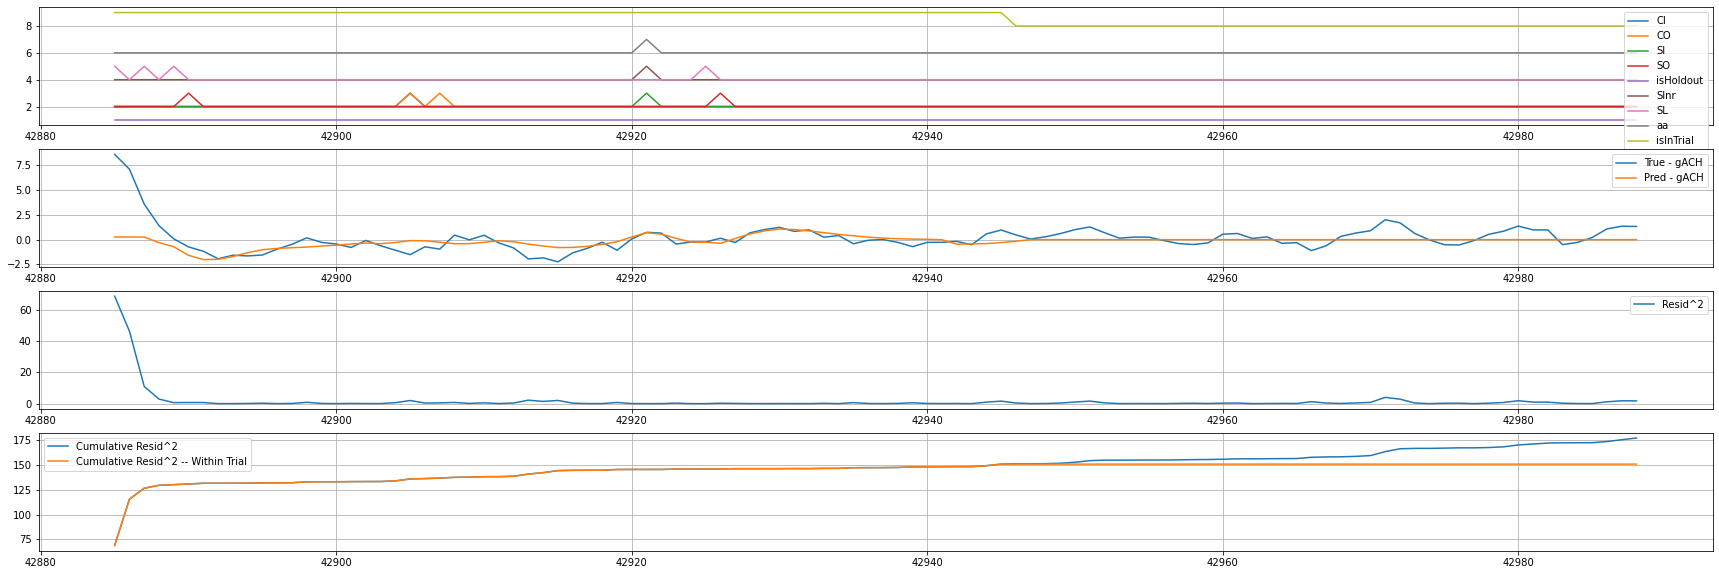

In [35]:
view_trial_kwargs = dict(y_col=y_col, pred_col=f'pred_{y_col}_{Xyd}_{Xyp}_base_simple_run_num__{run_num}', holdout_col=f'holdout_{y_col}_{Xyd}_{Xyp}_base_simple_run_num__{run_num}', dupe_col='dupe')
view_trial(df_inspect, 1071, **view_trial_kwargs)

In [23]:
dfrel_basis

,index,gDA,Ch2,gACH,rDA,cpo,cpn,cpx,rpo,rpn,...,holdout_gACH_0_0_base_simple_run_num__8,pred_gACH_0_0_base_simple_run_num__8,predALL_gACH_0_0_base_simple_run_num__8,holdout_iXyp=0_irun=9,holdout_gACH_0_0_base_simple_run_num__9,pred_gACH_0_0_base_simple_run_num__9,predALL_gACH_0_0_base_simple_run_num__9,resid2,resid2_wi_trial,resid2_wi_trial_hard
0,1183,-1.403055,0.224081,1.291100,-1.830134,1,1,1,0,0,...,0.0,0.233364,0.233364,0.0,0.0,0.249683,0.249683,1.084549,1.084549,NaN
1,1184,-1.186573,1.177903,1.948091,-1.206838,0,0,0,0,0,...,0.0,0.252894,0.252894,0.0,0.0,0.268615,0.268615,2.820638,2.820638,NaN
2,1185,-0.707389,-0.014280,1.808744,-1.191822,0,0,0,0,0,...,0.0,0.152467,0.152467,0.0,0.0,0.159378,0.159378,2.720409,2.720409,NaN
3,1186,0.190341,-0.543271,1.693770,-0.478138,0,0,0,0,0,...,0.0,0.089250,0.089250,0.0,0.0,0.092378,0.092378,2.564454,2.564454,NaN
4,1187,-0.526820,-0.752385,-0.079142,-0.593920,0,0,0,0,0,...,0.0,0.043680,0.043680,0.0,0.0,0.048871,0.048871,0.016387,0.016387,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216328,21842,NaN,0.153820,-0.552477,NaN,0,0,0,0,0,...,0.0,0.205361,0.205361,0.0,0.0,0.157296,0.157296,0.503778,NaN,NaN
2216329,21843,NaN,-0.496645,0.858026,NaN,0,0,0,0,0,...,0.0,0.264504,0.264504,0.0,0.0,0.226000,0.226000,0.399457,NaN,NaN
2216330,21844,NaN,-1.128380,1.403134,NaN,0,0,0,0,0,...,0.0,0.326968,0.326968,0.0,0.0,0.282942,0.282942,1.254828,NaN,NaN
2216331,21845,NaN,-0.275584,1.930229,NaN,0,0,0,0,0,...,0.0,0.169895,0.169895,0.0,0.0,0.108542,0.108542,3.318540,NaN,NaN


In [24]:
# hdf = dfrel_basis.copy()
# hdf['nTrial'] = hdf.groupby('file_num')['nTrial'].shift(20)
# hdf['nEndTrial'] = hdf.groupby('file_num')['nEndTrial'].shift(-20)
# hdf['diffTrialNums'] = hdf['nTrial'] - hdf['nEndTrial']
# hdf[hdf['diffTrialNums'] == 1]
# ((((dfrel_basis['photometryCenterInIndex'].cumsum() - dfrel_basis['photometrySideOutIndex'].cumsum())==1).replace(False, np.nan))*dfrel_basis['resid2'])
# holdout_df.groupby(['nTrial_filenum'])['resid2_wi_trial_short'].mean().sort_values(ascending=False).reset_index()

In [25]:
training_df[training_df['has_all_cols']&training_df['wi_trial_keep']].shape, df_train.shape

((972796, 437), (665077, 394))

In [26]:
((glm.predict(X_train) - y_train)**2).mean()

0.7512954662297322

In [27]:
df_train.shape, training_df[training_df['has_all_cols']&(training_df['wi_trial_keep'])].shape, df_holdout.shape, holdout_df[holdout_df['has_all_cols']&holdout_df['wi_trial_keep']].shape

((665077, 394), (972796, 437), (150724, 394), (219104, 437))

In [28]:
dfrel_basis_has_all_cols.shape

(1581817, 394)

In [29]:
pr(f'../../data/interim/{data_folder_src}/GLM_SIGNALS_INTERIM_{wt}_*')

'C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\data\\interim\\fig1\\GLM_SIGNALS_INTERIM_WT56_*'

In [30]:
# !conda install numba

In [31]:
# row_col_keeps['has_all_cols'][0].sum()

dfrel_basis[full_drop_basis]

NameError: name 'full_drop_basis' is not defined

In [ ]:
# (~dfrel_basis[f'holdout_iXyp={iXyp}_irun={irun}_iXyd={iXyd}'].isna()).sum()

In [ ]:
print('Num Training', (~dfrel_basis['holdout_iXyp=0_irun=0'].dropna().astype(bool)).sum())
print('Num Holdouts', (dfrel_basis['holdout_iXyp=0_irun=0'].dropna().astype(bool)).sum())
print('NaN Entries', dfrel_basis['holdout_iXyp=0_irun=0'].isna().sum())

print('Total Entries', (~dfrel_basis['holdout_iXyp=0_irun=0'].dropna().astype(bool)).sum() + (dfrel_basis['holdout_iXyp=0_irun=0'].dropna().astype(bool)).sum() + dfrel_basis['holdout_iXyp=0_irun=0'].isna().sum())
print('Len Entries', len(dfrel_basis))

In [ ]:
len(has_all_cols) - has_all_cols.sum()

In [ ]:
# GLM_SIGNALS_INTERIM_{wt}_dfrel_ft_setup['nTrial'].nunique()

# dfrel_ft_holdout['nTrial'].nunique()

# dfrel_ft_setup['nTrial_filenum'].nunique()

# dfrel_ft_holdout['nTrial_filenum'].nunique()

# dfrel_ft_holdout['nTrial_filenum'].nunique()/dfrel_ft_setup['nTrial_filenum'].nunique()